In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.4
2.7.0


# 1. 데이터의 전처리
- 명확한 1회 세션의 session ID를 포함하고 있지 않다. 그래서 UserID가 SessionID의 역할을 해야 한다.
- Rating 정보가 포함되어 있음. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않으므로, 무시하고 제외할 수 있음. -> Rating 3점 이상 반영 후 컬럼 삭제.
- 하지만, 직전에 봤던 영화가 마음에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있음. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 한다.  -> 3점 이상짜리만 반영.
- Time 항목에는 UTC time이 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있다. -> timestamp 변환.
- 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행.
- Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 어떻게 Session 단위로 해석할지에 주의.

In [2]:
# Library import
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [3]:
data_path = Path(r'C:/Users/user/Google 드라이브/AIFFEL/Exploration16/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows = None):
    data = pd.read_csv(data_path, sep = '::', header = None, usecols = [0, 1, 2, 3],
                      dtype = {0: np.int32, 1: np.int32, 2: np.int32},
                      nrows = nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
# data를 id와 시간 순서로 정렬해줍니다.
data.sort_values(['UserId', 'Time'], inplace = True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
data['Time'] = pd.to_datetime(data['Time'], unit= 's')
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


## 1.2 Session Length
- SessionId: 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자. 로그인하지 않았기 때문에 누군지 알 수 없어도 특정 행동 패턴을 SessionId 기준으로 모아서 분류해낼 수 있다.
- Session length: 같은 SessionId를 공유하는 데이터 행의 개수. 해당 세션의 사용자가 그 세션동안 몇 번의 액션을 취했는지(몇 개의 상품 정보를 클릭했는지)의 의미가 된다.

In [5]:
# 추천 시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저 수(세션 수)와 아이템 수이다.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [6]:
# 각 세션이 대략 몇 개의 클릭 데이터를 갖는지.
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
# 데이터에서 평점 3점 이상의 것들만 유효데이터로 삼아 필터링.
raw_data_size = len(data)
filtered_data = data[data['Rating'] >= 3]
filtered_data_size = len(data)
print(f'raw_data_size: {raw_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / raw_data_size:.2%}')

raw_data_size: 1000209, filtered_data_size: 1000209
Ratio of Remaining Data is 100.00%


In [8]:
# 필터된 데이터에서 별점 제외하기. 
filtered_data = filtered_data.drop(['Rating'], axis = 1)
filtered_data

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [28]:
# 필터된 데이터에서 각 세션이 대략 몇 개의 시청 데이터를 갖는지.
filtered_session_length = filtered_data.groupby('UserId').size()
filtered_session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [30]:
# 전체 데이터의 중간값과 평균
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [31]:
# 필터된 데이터의 중간값과 평균
filtered_session_length.median(), filtered_session_length.mean()

(81.0, 138.51266766020865)

In [10]:
# 전체 데이터의 최소값과 최대값
session_length.min(), session_length.max()

(20, 2314)

In [32]:
# 필터된 데이터의 최소값과 최대값
filtered_session_length.min(), filtered_session_length.max()

(1, 1968)

In [11]:
# 전체 데이터의 99.9% 순번째의 조회수
session_length.quantile(0.999)

1343.181000000005

In [33]:
# 필터된 데이터의 99.9% 순번째의 조회수
filtered_session_length.quantile(0.999)

1118.8860000000013

In [41]:
filtered_session_length[filtered_session_length <= 1118].index[0] 

1

In [38]:
filtered_long_session = filtered_session_length[filtered_session_length >= 1118].index[1]  # 숫자 및 기준조정
filtered_data[filtered_data['UserId']==filtered_long_session]

,UserId,ItemId,Time
278445,1680,3940,2000-11-20 08:20:46
279596,1680,2395,2000-11-20 08:20:46
278591,1680,3051,2000-11-20 08:21:46
279652,1680,1762,2000-11-20 08:21:46
280002,1680,376,2000-11-20 08:21:46
...,...,...,...
279465,1680,880,2000-11-21 22:14:07
280121,1680,540,2000-11-21 22:14:07
278469,1680,1266,2000-11-21 22:15:53
279644,1680,3508,2000-11-21 22:16:08


In [13]:
# 세션 길이 기준 하위 99.9% 까지의 분포 누적합을 시각화한 것.
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

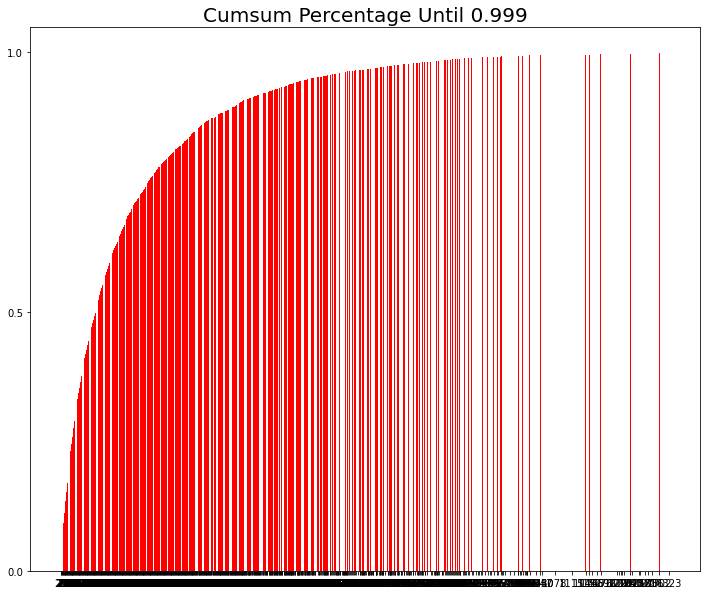

In [14]:
plt.figure(figsize = (12, 10))
plt.bar(x = length_percent_cumsum_999.index,
       height = length_percent_cumsum_999, color = 'red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.5))
plt.title('Cumsum Percentage Until 0.999', size = 20)
plt.show()

## 1.3 Session time

In [15]:
# 데이터의 시간 관련 정보
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [16]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [17]:
month_ago = latest - dt.timedelta(30)  # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]    # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
28225,195,2808,3,2003-02-02 21:08:38
27759,195,1254,4,2003-02-06 17:23:42
27921,195,1456,2,2003-02-08 00:07:32
28443,195,468,3,2003-02-11 17:42:36
28255,195,2748,1,2003-02-11 18:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


## 1.4 Data cleansing


In [18]:
# # short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# # 이를 위해 반복문을 통해 지속적으로 제거 합니다.
# def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
#     while True:
#         before_len = len(data)
#         data = cleanse_short_session(data, shortest)
#         data = cleanse_unpopular_item(data, least_click)
#         after_len = len(data)
#         if before_len == after_len:
#             break
#     return data

# def cleanse_short_session(data: pd.DataFrame, shortest):
#     session_len = data.groupby('UserId').size()
#     session_use = session_len[session_len >= shortest].index
#     data = data[data['UserId'].isin(session_use)]
#     return data

# def cleanse_unpopular_item(data: pd.DataFrame, least_click):
#     item_popular = data.groupby('ItemId').size()
#     item_use = item_popular[item_popular >= least_click].index
#     data = data[data['ItemId'].isin(item_use)]
#     return data

In [19]:
# data = cleanse_recursive(data, shortest = 2, least_click = 5)
# data

## 1.5 Train/Valid/Test split

In [20]:
# 고유한 유저, 영화를 찾아내는 코드 
user_unique = data['UserId'].unique() 
item_unique = data['ItemId'].unique() 

# 유저, 영화 indexing 하는 코드
user_to_idx = {v:k for k,v in enumerate(user_unique)} 
item_to_idx = {v:k for k,v in enumerate(item_unique)}

In [21]:
# 인덱싱 검증
temp_user_data = data['UserId'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   
    print('UserId column indexing OK!!')
    data['UserId'] = temp_user_data   
else:
    print('UserId column indexing Fail!!')

temp_item_data = data['ItemId'].map(item_to_idx.get).dropna()
if len(temp_item_data) == len(data):
    print('item column indexing OK!!')
    data['ItemId'] = temp_item_data
else:
    print('ItemId column indexing Fail!!')

data

UserId column indexing OK!!
item column indexing OK!!


,UserId,ItemId,Rating,Time
28225,0,0,3,2003-02-02 21:08:38
27759,0,1,4,2003-02-06 17:23:42
27921,0,2,2,2003-02-08 00:07:32
28443,0,3,3,2003-02-11 17:42:36
28255,0,4,1,2003-02-11 18:23:28
...,...,...,...,...
984731,102,773,4,2003-02-27 18:13:57
984682,102,75,4,2003-02-27 18:14:30
984475,102,326,3,2003-02-27 18:15:10
984660,102,563,2,2003-02-27 18:15:37


In [22]:
temp_user_data

28225       0
27759       0
27921       0
28443       0
28255       0
         ... 
984731    102
984682    102
984475    102
984660    102
984733    102
Name: UserId, Length: 1551, dtype: int64

In [23]:
temp_item_data.head(20)

28225     0
27759     1
27921     2
28443     3
28255     4
28281     5
28389     6
28391     7
27781     8
27764     9
28008    10
28482    11
28513    12
27895    13
27846    14
27901    15
27902    16
28241    17
33889    18
33994    19
Name: ItemId, dtype: int64

In [24]:
type(data['UserId'][58836])

numpy.int64

In [25]:
# Train, validation, test dataset 분량 설정
data_length = len(session_length)
train_length = int(data_length*0.8)
val_length = int(data_length*0.1)
test_length = data_length - train_length - val_length

In [26]:
# data에 대한 정보 살펴보기
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
         f'\t Events: {len(data)}\n'
         f'\t Sessions: {data["UserId"].nunique()}\n'
         f'\t Items: {data["ItemId"].nunique()}\n'
         f'\t First Time : {data["Time"].min()}\n'
         f'\t Last Time : {data["Time"].max()}\n')

In [27]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

NameError: name 'tr' is not defined

In [ ]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1)) # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test=  indexing(test, id2idx)

In [ ]:
# 데이터 저장
save_path = data_path / 'exp_processed'
save_path.mkdir(parents= True, exist_ok = True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 2. 미니배치의 구성
- Session-parallel mini-batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성.
- 전 단계에서 session 단위를 어떻게 정의했느냐에 따라 SPMB가 굳이 필요하지 않을수도 있음.

## 2.1 Session dataset

In [ ]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId
        
    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() +1, dtype = np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [ ]:
# train 데이터로 Session dataset 객체를 만들고 인스턴스 변수들 살펴보기
# click_offsets: 각 세션이 시작된 인덱스
# session_idx = 각 세션을 인덱싱한 np.array
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

# 3. 모델 구성
- 실습 코드 내역을 참조하여 다양하게 모델 구조를 시도.

# 4. 모델 학습
- 하이퍼 파라미터를 변경해보며 검증. 실습코드에 언급되었던 Recall, MRR 개념도 함께 관리되도록.

# 5. 모델 테스트
- 미리 구성한 테스트셋을 바탕으로 Recall, MRR 확인.

# Rubric
- 1. Movielens dataset을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다. -> 데이터셋의 면밀한 분석을 토대로 세션 단위 정의과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
- 2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. -> 적절한 epoch 만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서 Recall, MRR이 개선되는 것이 확인된다.
- 3. 세션 정의, 모델 구조, 하이퍼 파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다. -> 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.
